# Coronavirus Disease (COVID-19) Situation Reports – WHO/Devakumar kp

### Aprendizagem Supervisionada

Ana Margarida Ruivo Loureiro - 201705749

João Martins

João Cardoso

FEUP

# Abstract

Este notebook foi desenvolvido no âmbito de um projeto da cadeira de IART do curso de MIEIC da FEUP. Tem como objetivo a construção de modelos de regressão com base em algoritmos de aprendizagem supervisionada. O dataset usado neste projeto chama-se Coronavirus Disease (COVID-19) Situation Reports, sendo diariamente atualizado com valores dados pela OMS, e pode ser encontrado no link: https://www.kaggle.com/imdevskp/corona-virus-report.

# Introdução 

O problema em análise é a inferência do número de casos confirmados de infetados, de mortes e de recuperados num determinado local. A latitude e a longitude, bem como o número de dias passados desde o início da pandemia e dados das contagens do dia anterior (infetados, mortes e recuperados), são as variáveis independentes usadas para solucionar o problema. Escolhemos 4 algoritmos de regressão: Linear Regression, K Nearest Neighbours, Random Forest e Support Vector Regression.

Para isso fizemos uma análise e um tratamento dos dados do dataset, passando depois à implementação dos algoritmos escolhidos e, finalmente, tiramos conclusões com base nos resultados obtidos.

# Dataset

O nosso dataset providencia-nos dados geográficos e contagem de casos confirmados, óbitos e recuperados do Covid-19 num periodo de  4 meses (22 de janeiro de 2020 a 5 de maio de 2020) em vários países. O objetivo será extrair informação dos dados de forma a podermos construir um modelo de regressão capaz de prever as contagens tendo por base os fatores disponiveis (localização geográfica, dia e contagem anterior). Assim sendo é necessário partir dos dados iniciais e proceder a um pré-processamento para tratar os dados e poder-se então utlizar os algoritmos de regressão que pretendemos utilizar.

### Variáveis independentes

Como foi supramencionado, pretendemos utilizar certos fatores para fundamentarmos a nossa previsão (partindo dos dados do dataset). Estes então serão as coordenadas geográficas (Latitude e Longitude), número de dias desde o inicio da previsão (ou seja, 22 de janeiro) e contagens anteriores (número de casos confirmados, óbitos e recuperados do dia anterior).

### Variáveis Dependentes

Os valores que vamos prever serão os números de casos confirmados, óbitos e recuperados, sendo então estas as nossas variáveis independentes.

# Tratamento de dados

Para podermos obter resultados fiáveis, é preciso haver um tratamento dos dados que vem do dataset.
Pegando dos dados processados anteriormente feito inicialmente, começamos por extrai-los do ficheiro para podermos manipulá-los.

In [11]:
import pandas as pd

covid_data = pd.read_csv('covid_19_clean_complete.csv')
covid_data

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
0,NaN,Afghanistan,33.000000,65.000000,1/22/20,0,0,0
1,NaN,Albania,41.153300,20.168300,1/22/20,0,0,0
2,NaN,Algeria,28.033900,1.659600,1/22/20,0,0,0
3,NaN,Andorra,42.506300,1.521800,1/22/20,0,0,0
4,NaN,Angola,-11.202700,17.873900,1/22/20,0,0,0
...,...,...,...,...,...,...,...,...
27451,NaN,Western Sahara,24.215500,-12.885800,5/4/20,6,0,5
27452,NaN,Sao Tome and Principe,0.186360,6.613081,5/4/20,23,3,4
27453,NaN,Yemen,15.552727,48.516388,5/4/20,12,2,0
27454,NaN,Comoros,-11.645500,43.333300,5/4/20,3,0,0


De seguida, após uma análise, verificou-se a presença de entrada respeitantes a navios que nalgum momento tiveram casos de Covid-19 e não estão portanto associados a nenhum país particular.
Além disso, consideramos que estes dados iriam criar ruído, pelo que optamos por ignorá-los e remover dos dados em análise.

In [12]:
covid_data = covid_data.drop(covid_data[covid_data['Province/State']=='Grand Princess'].index)
covid_data = covid_data.drop(covid_data[covid_data['Province/State']=='Diamond Princess'].index)
covid_data = covid_data.drop(covid_data[covid_data['Country/Region']=='Diamond Princess'].index)
covid_data = covid_data.drop(covid_data[covid_data['Country/Region']=='MS Zaandam'].index)
covid_data = covid_data.reset_index()
del covid_data['index']
covid_data

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
0,NaN,Afghanistan,33.000000,65.000000,1/22/20,0,0,0
1,NaN,Albania,41.153300,20.168300,1/22/20,0,0,0
2,NaN,Algeria,28.033900,1.659600,1/22/20,0,0,0
3,NaN,Andorra,42.506300,1.521800,1/22/20,0,0,0
4,NaN,Angola,-11.202700,17.873900,1/22/20,0,0,0
...,...,...,...,...,...,...,...,...
27035,NaN,Western Sahara,24.215500,-12.885800,5/4/20,6,0,5
27036,NaN,Sao Tome and Principe,0.186360,6.613081,5/4/20,23,3,4
27037,NaN,Yemen,15.552727,48.516388,5/4/20,12,2,0
27038,NaN,Comoros,-11.645500,43.333300,5/4/20,3,0,0


A maioria das entradas da coluna **Province/State** tem valores nulos, pelo que procedemos a eliminá-los. Além disso, como ter uma entrada para uma região e país não é muito relevante, optamos por agregar as duas informações numa só coluna denominada de **Local**.

In [13]:
import numpy as np

covid_data['Province/State'] = covid_data.replace(np.nan, '', regex=True)
cols = ['Province/State', 'Country/Region']
covid_data['Local'] = covid_data[cols].apply(lambda row: ' / '.join(row.values.astype(str)) if row.values[0] != '' else ''.join(row.values.astype(str)), axis=1)
del covid_data['Province/State']
del covid_data['Country/Region']
covid_data

,Lat,Long,Date,Confirmed,Deaths,Recovered,Local
0,33.000000,65.000000,1/22/20,0,0,0,Afghanistan
1,41.153300,20.168300,1/22/20,0,0,0,Albania
2,28.033900,1.659600,1/22/20,0,0,0,Algeria
3,42.506300,1.521800,1/22/20,0,0,0,Andorra
4,-11.202700,17.873900,1/22/20,0,0,0,Angola
...,...,...,...,...,...,...,...
27035,24.215500,-12.885800,5/4/20,6,0,5,Western Sahara
27036,0.186360,6.613081,5/4/20,23,3,4,Sao Tome and Principe
27037,15.552727,48.516388,5/4/20,12,2,0,Yemen
27038,-11.645500,43.333300,5/4/20,3,0,0,Comoros


De seguida, vamos converter as datas em contagem de dias desde o início do dataset (22 de janeiro de 2020)

In [14]:
covid_data['Date'] = pd.to_datetime(covid_data['Date'],format='%m/%d/%y')
covid_data['Date'] -= pd.to_datetime("2020-01-22")
covid_data['Date'] /= np.timedelta64(1,'D')
covid_data = covid_data.rename(columns  = {'Date':'Days Passed'})
covid_data

,Lat,Long,Days Passed,Confirmed,Deaths,Recovered,Local
0,33.000000,65.000000,0.0,0,0,0,Afghanistan
1,41.153300,20.168300,0.0,0,0,0,Albania
2,28.033900,1.659600,0.0,0,0,0,Algeria
3,42.506300,1.521800,0.0,0,0,0,Andorra
4,-11.202700,17.873900,0.0,0,0,0,Angola
...,...,...,...,...,...,...,...
27035,24.215500,-12.885800,103.0,6,0,5,Western Sahara
27036,0.186360,6.613081,103.0,23,3,4,Sao Tome and Principe
27037,15.552727,48.516388,103.0,12,2,0,Yemen
27038,-11.645500,43.333300,103.0,3,0,0,Comoros


Por fim, adicionar as colunas da contagem do dia anterior. Este passo é um pouco mais longo tendo em conta o numero de linhas e a procura pelo valor anterior.

In [ ]:
covid_data['Conf. Prev.'] = covid_data.apply(lambda row: 
                                                      covid_data[(covid_data['Local'] == row['Local']) & (covid_data['Days Passed'] == row['Days Passed']-1)]['Confirmed'].item()
                                                      if row['Days Passed'] > 0 else 0,axis=1)
covid_data['Deaths Prev.'] = covid_data.apply(lambda row: 
                                                      covid_data[(covid_data['Local'] == row['Local']) & (covid_data['Days Passed'] == row['Days Passed']-1)]['Deaths'].item()
                                                      if row['Days Passed'] > 0 else 0,axis=1)
covid_data['Recov. Prev.'] = covid_data.apply(lambda row: 
                                                      covid_data[(covid_data['Local'] == row['Local']) & (covid_data['Days Passed'] == row['Days Passed']-1)]['Recovered'].item()
                                                      if row['Days Passed'] > 0 else 0,axis=1)
covid_data

In [ ]:
with pd.ExcelWriter('covid19_dataset_final.xlsx') as writer:
    covid_data.to_excel(writer)

# Abordagem

### Funções comuns

In [ ]:
from sklearn.model_selection import train_test_split

#colunas em que vamos basear as previsões
x_columns = ['Lat','Long','Days Passed', 'Conf. Prev.','Deaths Prev.','Recov. Prev.']
#colunas que queremos prever
y_columns = ['Confirmed','Deaths','Recovered']

from sklearn.preprocessing import StandardScaler

In [ ]:
# Import the model we are using
from sklearn.metrics import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR

def runRegressor(params,algorithm) :

    if algorithm == 'RF' : 
        al = RandomForestRegressor(n_jobs =2,max_depth=100,
                              n_estimators=params[0] , max_samples=params[1], max_features=params[2], min_samples_split=params[3])
    elif algorithm == 'KNN':
        if(len(params) == 4):
            al = KNeighborsRegressor(n_neighbors=params[0],weights=params[1],algorithm=params[2],leaf_size=params[3],n_jobs=2)
        else:
            al = KNeighborsRegressor(n_neighbors=params[0],weights=params[1],metric=params[2],algorithm=params[3],leaf_size=params[4],n_jobs=2)
    elif algorithm == 'SVR':
        regressor = SVR(kernel=params[0], epsilon=params[1], C=params[2], gamma=params[3],cache_size=1000)
        #wrapper
        al = MultiOutputRegressor(regressor)
        
    #aplicar a função de fit ao set de treino
    al.fit(X_train,y_train)
    #fazer previsões do set de teste usando 
    predictions = al.predict(X_test)
    y_pred = predictions

    #tratar dos resultados
    predictions = pd.DataFrame(data=predictions,columns=['Confirmed Prediction','Deaths Prediction','Recovered Prediction'])

    #buscar os locais para apresentar as previsoes, ja que nao foram usados no modelo de regressão
    predictions['Local'] = unscaled_test.apply(lambda row: covid_data.loc[(covid_data['Lat'] == row['Lat']) & (covid_data['Long'] == row['Long']),'Local'].iloc[0],axis=1).tolist()

    #arredondar os valores para inteiros, com teto
    predictions['Confirmed Prediction'] = predictions['Confirmed Prediction'].apply(np.ceil)
    predictions['Deaths Prediction'] = predictions['Deaths Prediction'].apply(np.ceil)
    predictions['Recovered Prediction'] = predictions['Recovered Prediction'].apply(np.ceil)

    #comparar os valores previstos e reais guardar a diferença nas contagens
    predictions['Confirmed Actual'] = unscaled_test['Confirmed'].tolist()
    predictions['Deaths Actual'] = unscaled_test['Deaths'].tolist()
    predictions['Recovered Actual'] = unscaled_test['Recovered'].tolist()
    #colocar o numero de dias passados para ser mais facil analisar
    predictions['Days Passed'] = unscaled_test['Days Passed'].tolist()

    predictions = predictions[['Days Passed','Local', 'Confirmed Prediction', 'Confirmed Actual','Deaths Prediction', 'Deaths Actual','Recovered Prediction','Recovered Actual']]
    
    mse = mean_squared_error(y_test,y_pred)
    mae = mean_absolute_error(y_test,y_pred)
    r2  = r2_score(y_test,y_pred)
    
    results = {"params": params, "data": predictions,"mse" : mse, "mae": mae,"r2":r2}
    return results


## K Nearest Neighbours
Este dataset que processamos permite-nos agrupar certos fatores relevantes como a posição geográfica e contagem dos dias anteriores para  poder-se relacionar certos pontos (entradas de dados) e obter uma previsão dos dados tendo em conta aquelas que estão mais próximas, que é em que se baseia o algoritmo **K Nearest neighbours**.
Já que pretendemos construir um modelo de regressão destes dados, vamos recorrer à ferramenta *scikit-learn* para utilizar os seus algoritmos de regressão, nos quais se encontra o **KNeighborsRegressor**, que será o escolhido para aplicar o KNN.

### KNeighborsRegressor
#### Parâmetros da pesquisa
* **n_neighbors**: número de vizinhos para usar. Para efeitos de testes serão testados os valores:
    * *1*, *3*, *7*, *10*, *15*
* **weights**: função de peso utilizado na previsão. Opções a testar:
    * *uniform*: pesos uniformes, todos os pontos na vizinhança são pesados igualmente
    * *distance*: pesos influenciados pela distância ao ponto de pesquisa, em que pontos vizinhos mais pertos do ponto de pesquisa terão mais influência do que aqueles mais afastados
* **algorithm**: algoritmo usado para a função de **fit**. Opções a usar:
    * *kd_tree*, *ball_tree*, *brute*
* **leaf_size**: tamanho uma folha a ser usada pela função de fit com árvore (KDTree e BallTree)
    * *10*, *30*: default, *70*, *150*, *300*
* **metric**: função de métrica da distância, a usar com os pesos baseados na distância. Opções a testar:
    * *euclidean*, *chebyshev*, *manhattan* 
* **n_jobs**: definir nº de processos para paralelizar os trabalhos (otimização do tempo de pesquisa, não influencia a qualidade dos resultados obtidos)
    * *None*: não há paralelismo (usar em debug)
    * *-1*: todos os cpu's são usados
    
### Criação dos sets de treino e teste
Procedemos então à criação de sets para podermos treinar o nosso modelo, e por fim testá-lo. Antes disso, escalamos os valores para ficarem normalizados.

In [9]:
#criar set de treino e teste
X_train, X_test, y_train, y_test = train_test_split(covid_data[x_columns], covid_data[y_columns], test_size=0.0096)

scaler = StandardScaler()

scaler.fit(X_train)
X_train = scaler.transform(X_train)
unscaled_test = X_test.join(y_test)
X_test = scaler.transform(X_test)

### Execução
Uma vez feita a preparação dos dados, avançamos então para a execução. Esta primeira será feita com os parâmetros por defeito, pelo de seguida passamos a exploração dos resultados não só com estes parâmetros, mas também com os outros acima mencionados.

Os parâmetros desta primeira execução são:
* *n_neighbors* = 5
* *weights* = 'uniform'
* *algorithm* = 'auto'
* *leaf_size* = 30
* *metric* = 'euclidean' (porque o default é minkowski como parâmetro p=2, resultando na distância euclideana)


In [10]:
#correr o default 
regressorExample = runRegressor((5,'uniform','auto',30),'KNN')["data"]
with pd.ExcelWriter('covid19_knn_regressor_example.xlsx') as writer:
    regressorExample.to_excel(writer)
    
regressorExample

,Days Passed,Local,Confirmed Prediction,Confirmed Actual,Deaths Prediction,Deaths Actual,Recovered Prediction,Recovered Actual
0,49.0,Sri Lanka,3.0,2,0.0,0,1.0,1
1,12.0,Ningxia / China,36.0,31,0.0,0,1.0,1
2,62.0,New South Wales / Australia,725.0,818,6.0,7,4.0,4
3,14.0,North Macedonia,0.0,0,0.0,0,0.0,0
4,98.0,Zambia,98.0,97,3.0,3,51.0,54
...,...,...,...,...,...,...,...,...
255,88.0,New Caledonia / France,18.0,18,0.0,0,16.0,15
256,15.0,Victoria / Australia,4.0,4,0.0,0,0.0,0
257,19.0,South Sudan,0.0,0,0.0,0,0.0,0
258,94.0,United Arab Emirates,9493.0,9813,66.0,71,1803.0,1887


Tendo a base de uma execução feita, podemos mecanizar este processo para testar as várias combinações possíveis e encontrar qual a que melhores resultados produz.

In [8]:
n_neighbors = [1,3,7,10,15]
uni_wgts = ['uniform']
dist_wgts = ['distance']
metric = ['euclidean','manhattan','chebyshev']
bf_algorithm = ['brute']
tree_algorithm = ['kd_tree','ball_tree']
leaf_size = [10,30,70,150,300]

import itertools

uniform_tree_params = {"n_neighbors" : n_neighbors, "weigths" : uni_wgts, "algorithm": tree_algorithm, "leaf_size" : leaf_size}
uniform_bf_params = {"n_neighbors" : n_neighbors, "weigths" : uni_wgts, "algorithm": bf_algorithm, "leaf_size" : leaf_size}
dist_tree_params = {"n_neighbors" : n_neighbors, "weigths" : dist_wgts, "metric": metric, "algorithm": tree_algorithm, "leaf_size" : leaf_size}
dist_bf_params = {"n_neighbors" : n_neighbors, "weigths" : dist_wgts, "metric": metric, "algorithm": bf_algorithm, "leaf_size" : leaf_size}

combinations = [] 
for p in itertools.product(*uniform_tree_params.values()):
    combinations.append(p)
for p in itertools.product(*uniform_bf_params.values()):
    combinations.append(p)
for p in itertools.product(*dist_tree_params.values()):
    combinations.append(p)
for p in itertools.product(*dist_bf_params.values()):
    combinations.append(p)
 
print("Number of combinations: %d" % len(combinations))

Number of combinations: 300


In [10]:
import time

beginning = time.time()
results = []
i = 0
for params in combinations:
    start_time = time.time()
    collect_data = runRegressor(params,'KNN')
    t =  round((time.time()-start_time),4)
    results.append(collect_data)
    write_data = collect_data['data']
    if len(collect_data['params']) == 4:
        data_params = {'Params':  [collect_data['params'][0],collect_data['params'][1],collect_data['params'][2],collect_data['params'][3]]}
    else:
         data_params = {'Params':  [collect_data['params'][0],collect_data['params'][1],collect_data['params'][2],collect_data['params'][3],collect_data['params'][4]]} 
    data_stats = {'Stats':  [collect_data['mse'], collect_data['mae'], collect_data['r2']]}
    data_time = {'Time':  [t]}
    df1 = pd.DataFrame(data_params, columns = ['Params'])
    df2 = pd.DataFrame(data_stats, columns = ['Stats'])
    df3 = pd.DataFrame(data_time, columns = ['Time'])
    write_data = pd.concat([df1,df2,df3,write_data], ignore_index=True, axis=1)
    with pd.ExcelWriter('Results_KNN/knn' + str(i) + '.xlsx') as writer:
         write_data.to_excel(writer)
    i+=1
    
    
print("Time elapsed for testing all combinations: %s seconds" % round((time.time()-beginning),4))

NameError: name 'X_train' is not defined

### Extração dos Resultados de Ficheiros

Uma vez que a execução de todas as diferentes combinações exige tempo de execução, assim como recursos computacionais, os resultados foram guardados em formato xlsx de forma a puderem ser novamente extraídos para análise sem terem de ter de ser executadas inúmeras vezes.

Assim, de seguida apresenta-se o processamento dos dados recolhidos dos ficheiros para que possam continuar a ser analisados normalmente.

In [1]:
import pandas as pd
import math
results_knn = []

for i in range(300):
    dfs = pd.read_excel('Results_KNN/knn' + str(i) + '.xlsx',index_col=0)
    param1 = dfs[0][0]
    param2 = dfs[0][1]
    param3 = dfs[0][2]
    param4 = dfs[0][3]
    param5 = dfs[0][4]
    MSE = dfs[1][0]
    MAE = dfs[1][1]
    R2 = dfs[1][2]
    ti = dfs[2][0]
    del dfs[0]
    del dfs[1]
    del dfs[2]
    dfs.rename(columns={list(dfs)[0]: "Days Passed",list(dfs)[1]: "Local", list(dfs)[2]: "Confirmed Prediction",
                  list(dfs)[3]:"Confirmed Actual",list(dfs)[4]:"Deaths Prediction", list(dfs)[5]: "Deaths Actual", 
                  list(dfs)[6]: "Recovered Prediction", list(dfs)[7]:"Recovered Actual" }, inplace=True)
    r = {'params': (param1,param2, param3, param4,param5), 
                  'time':ti,'mse': MSE, 'mae': MAE, 'r2': R2, 'data': dfs}
    results_knn.append(r)
    

## Random Forest 

O algoritmo Random Forest é uma técnica capaz de executar tanto tarefas de regressão como de classificação com o uso de árvores de decisão múltipla. 

Este algoritmo treina cada árvore de decisão de com uma amostra diferente. Assim, são combinados os resultados obtidos pelas múltiplas árvores de decisão para determinar o output final, ao invés de apenas depender de apenas uma árvore de decisão. Isto permite obter resultados com melhor desempenho.

### Random Forest Regressor

Para a sua implementação irá ser usado o **Random Forest Regressor** presente na ferramenta scikitlearn. Neste caso a previsão será a média da combinação dos diferentes resultados das várias árvores de decisão.

#### Parâmetros da pesquisa

* **n_estimators**: número de árvores a utilizar
    * *100*, *500*, *1000*
* **max_samples**: percentagem de elementos do set de treino usado para fazer a amostra de bootstrap a ser usada em cada árvore de decisão
    * *default*, *0.10*, *0.25*, *0.5*
* **max_features**: O número de features que é aleatoriamente selecionado na amostra para cada ponto de divisão dos nós (split point) 
    * *default*, *1*, *2*, *3*, *4*, *5*
* **min_samples_split**: número minimo de amostras necessárias para dividir o nó
    * *2*, *4*
* **max_depth**: a profundidade máxima permitida nas árvores de decisão
    * *100*
* **n_jobs**: definir nº de processos para paralelizar os trabalhos (otimização do tempo de pesquisa, não influencia a qualidade dos resultados obtidos)
    * *2*: 2 cpu's são usados
    
### Criação dos sets de treino e teste
Procedemos então à criação de sets para podermos treinar o nosso modelo, e por fim testá-lo. Antes disso, escalamos os valores para ficarem normalizados.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(covid_data[x_columns], covid_data[y_columns], test_size=0.0096)

scaler.fit(X_train)
X_train = scaler.transform(X_train)
unscaled_test = X_test.join(y_test)
X_test = scaler.transform(X_test)

### Execução

Uma vez feita a preparação dos dados, avançamos então para a execução.

Para este algoritmo foi mecanizado o processo de obtenção de resultados de forma a para testar as várias combinações possíveis e encontrar qual a que melhores resultados produz.

Assim, as diferentes combinações aplicadas assumem combinações dos seguintes valores nos parâmetros:
* n_estimators = 100,500,1000
* max_samples = None,0.10,0.25,0.5
* max_features = None,1,2,3,4,5
* min_samples_split = 2,4

In [ ]:
n_estimators = [100,500,1000]
max_samples = [None,0.10,0.25,0.5]
max_features = [None,1,2,3,4,5]
min_samples_split = [2,4]

import itertools

c = {"n_estimators" : n_estimators , 'max_samples': max_samples, "max_features" : max_features, "min_samples_split": min_samples_split}
combinations = [] 
for p in itertools.product(*c.values()):
    combinations.append(p)

In [ ]:
import time

results_rf = []
i = 0
for params in combinations:
    start_time = time.time()
    collect_data = runRegressor(params,'RF')
    t =  round((time.time()-start_time),4)
    results_rf.append(collect_data)
    write_data = collect_data['data']
    data_params = {'Params':  [collect_data['params'][0],collect_data['params'][1],collect_data['params'][2],collect_data['params'][3]]}
    data_stats = {'Stats':  [collect_data['mse'], collect_data['mae'], collect_data['r2']]}
    data_time = {'Time':  [t]}
    df1 = pd.DataFrame(data_params, columns = ['Params'])
    df2 = pd.DataFrame(data_stats, columns = ['Stats'])
    df3 = pd.DataFrame(data_time, columns = ['Time'])
    write_data = pd.concat([df1,df2,df3,write_data], ignore_index=True, axis=1)
    with pd.ExcelWriter('random_forest' + str(i) + '.xlsx') as writer:
         write_data.to_excel(writer)
    i+=1
    


### Extração dos Resultados de Ficheiros

Como já explicada a razão anteriormente, vamos agora passar a extração e processamento dos dados recolhidos dos ficheiros para que possam continuar a ser analisados normalmente.

In [2]:
import pandas as pd
import math
results_rf = []

for i in range(144):
    dfs = pd.read_excel('Results_RandomForest/random_forest' + str(i) + '.xlsx',index_col=0)
    nestimators = dfs[0][0]
    maxsamples = dfs[0][1]
    maxfeatures = dfs[0][2]
    if math.isnan(maxsamples):
        maxsamples = 'Default'
    if math.isnan(maxfeatures):
        maxfeatures = 'Default'
    min_samplessplit = dfs[0][3]
    MSE = dfs[1][0]
    MAE = dfs[1][1]
    R2 = dfs[1][2]
    ti = dfs[2][0]
    del dfs[0]
    del dfs[1]
    del dfs[2]
    dfs.rename(columns={list(dfs)[0]: "Days Passed",list(dfs)[1]: "Local", list(dfs)[2]: "Confirmed Prediction",
                  list(dfs)[3]:"Confirmed Actual",list(dfs)[4]:"Deaths Prediction", list(dfs)[5]: "Deaths Actual", 
                  list(dfs)[6]: "Recovered Prediction", list(dfs)[7]:"Recovered Actual" }, inplace=True)
    r = {'params': (nestimators,maxsamples, maxfeatures, min_samplessplit), 
                  'time':ti,'mse': MSE, 'mae': MAE, 'r2': R2, 'data': dfs}
    results_rf.append(r)
    


## **Support Vector Regression** 

utiliza conceitos semelhantes aos aplicados no algoritmo de Support Vector Machine para aplicações em métodos de regressão.

Deste modo serão expostos alguns conceitos teóricos fundamentais para que se possa compreender este algoritmo:
-  **Hyper Plane** : Linha que se tentará melhor adaptar aos valores existentes.
-  **Boundary line** : Margens da hyperplane que separam os valores existentes.
-  **Support vectors** : Os pontos mais perto da "boundary line". A distância dos pontos é a minima.
    
Assim, neste algoritmo o objetivo é considerar os valores dentro da margem, ou seja aqueles com menor erro entre eles. Assim o objetivo é descobrir um hyper plain que mais se aproxime aos valores existentes, ou seja, que se tenha uma distância minima a um maior número destes pontos.

Desta forma a aplicação deste algoritmo vai ser feita auxiliando-nos da implementação presente na ferramenta **scikit-learn**. 

### MultiOutputRegressor
O uso de apenas este algoritmo não possibilita a previsão para mais do que um output.
Assim, foi preciso auxiliarmo-nos num "wrapper" - **MultiOutputRegressor** - de forma a conseguirmos
contornar este problema. Esta classe irá criar uma instância do modelo para cada um dos outputs do problema.

Contudo como referido, é criado um modelo separado para cada output. Consequentemente, esta
solução não consegue garantir a dependência entre as várias varíáveis, ou seja, assume que
os outputs são totalmente independentes uns dos outros. 

No contexto deste problema os outputs tem relação entre si uma vez que o maior número de casos confirmados 
implicam um maior número de mortes e recuperados. Apesar disto, decidimos avançar na mesma com este algoritmo uma
vez que a dependência entre os vários outputs poderá não ser assim tão significativa para os resultados finais.

#### Parâmetros da pesquisa

   * **kernel** : Método para usar um classificador linear em problemas não lineares.
     * poly
   * **epsilon**: Define a margem de tolerância onde não é atribuida penalidade a erros.
     * 0.1(default),0.2,1
   * **cache size**: Especifica tamanho da cache do kernel; permite diminuir o tempo de execução 
     * 500    
   * **C** : Relativo à penalização dada a classificações incorretas. Quanto maior o valor, menor será a margem do hyperplane e consequentemente tolera menos erros pelo que os valores serão mais "corretos". 
     * 1(default),5,10
   * **gamma**: Coeficiente para o kernel. 
      * scale (default):  1 / (n_features * X.var())  , auto:  1 / n_features
      
   
### Criação dos sets de treino e teste
Procedemos então à criação de sets para podermos treinar o nosso modelo, e por fim testá-lo. Antes disso, escalamos os valores para ficarem normalizados.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(covid_data[x_columns], covid_data[y_columns], test_size=0.0096)

scaler = StandardScaler()

scaler.fit(X_train)
X_train = scaler.transform(X_train)
unscaled_test = X_test.join(y_test)
X_test = scaler.transform(X_test)

### Execução

Uma vez feita a preparação dos dados, avançamos então para a execução.

Para este algoritmo foi mecanizado o processo de obtenção de resultados de forma a para testar as várias combinações possíveis e encontrar qual a que melhores resultados produz.


Tendo a base de uma execução feita, podemos mecanizar este processo para testar as várias combinações possíveis e encontrar qual a que melhores resultados produz.

Assim, as diferentes combinações aplicadas assumem combinações dos seguintes valores nos parâmetros:
* kernel = poly
* epsilon = 0.1,0.2,1
* cache_size = 1000
* C = 1,5,10
* gamma = auto, scale

In [ ]:
kernel=['poly']
epsilon=[0.1,0.2,1]
C=[1,5,10]
gamma = ['scale','auto']
import itertools

params = {"kernel" : kernel, "epsilon" : epsilon, "C": C, "gamma" : gamma}

combinations = [] 
for p in itertools.product(*params.values()):
    combinations.append(p)
 

In [ ]:
import time

results_svr = []
i = 0
for params in combinations:
    start_time = time.time()
    collect_data = runRegressor(params)
    t =  round((time.time()-start_time),4)
    results_svr.append(collect_data)
    write_data = collect_data['data']
    data_params = {'Params':  [collect_data['params'][0],collect_data['params'][1],collect_data['params'][2],collect_data['params'][3]]}
    data_stats = {'Stats':  [collect_data['mse'], collect_data['mae'], collect_data['r2']]}
    data_time = {'Time':  [t]}
    df1 = pd.DataFrame(data_params, columns = ['Params'])
    df2 = pd.DataFrame(data_stats, columns = ['Stats'])
    df3 = pd.DataFrame(data_time, columns = ['Time'])
    write_data = pd.concat([df1,df2,df3,write_data], ignore_index=True, axis=1)
    with pd.ExcelWriter('svr' + str(i) + '.xlsx') as writer:
         write_data.to_excel(writer)
    i+=1
    

### Extração dos Resultados de Ficheiros

Uma vez que a execução de todas as diferentes combinações exige tempo de execução, assim como recursos computacionais, os resultados foram guardados em formato xlsx de forma a puderem ser novamente extraídos para análise sem terem de ter de ser calculados inúmeras vezes.

Assim de seguida efetua-se a extração dos dados dos ficheiros.

In [3]:
import pandas as pd
import math
results_svr = []

import itertools

for i in range(18):
    dfs = pd.read_excel('Results_SVR/svr' + str(i) + '.xlsx')
    kernel = dfs[0][0]
    epsilon = dfs[0][1]
    C = dfs[0][2]
    gamma = dfs[0][3]
    MSE = dfs[1][0]
    MAE = dfs[1][1]
    R2 = dfs[1][2]
    ti = dfs[2][0]
    del dfs[0]
    del dfs[1]
    del dfs[2]
    del dfs[3]
    dfs.rename(columns={list(dfs)[0]: "Days Passed",list(dfs)[1]: "Local", list(dfs)[2]: "Confirmed Prediction",
                  list(dfs)[3]:"Confirmed Actual",list(dfs)[4]:"Deaths Prediction", list(dfs)[5]: "Deaths Actual", 
                  list(dfs)[6]: "Recovered Prediction", list(dfs)[7]:"Recovered Actual" }, inplace=True)
    r = {'params': (kernel,epsilon, C, gamma), 
                  'time':ti,'mse': MSE, 'mae': MAE, 'r2': R2, 'data': dfs}
    results_svr.append(r)

## Linear Regression

Um dos algoritmos que decidimos usar foi o de regressão linear, devido à sua simplicidade. É de esperar que os resultados gerados não sejam muito bons, pelo que será usado como base de comparação com os outros algoritmos.

Fórmula de regressão linear:

[predicted_confirmed,predicted_deaths,predicted_recovered] = M * [lat,long,days_passed,confirmed_previous_day,deaths_previous_day,recovered_previous_day] + B

M é a matriz coeficiente

B é a matriz residual

In [4]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split

reg = linear_model.LinearRegression()

X_train, X_test, y_train, y_test = train_test_split(covid_data[x_columns], covid_data[y_columns], test_size=0.0096)
unscaled_test = X_test.join(y_test)

reg.fit(X_train,y_train)

NameError: name 'covid_data' is not defined

In [5]:
#Matriz coeficiente
print(reg.coef_)
#Matriz residual
print(reg.intercept_)

AttributeError: 'LinearRegression' object has no attribute 'coef_'

Os valores da matrix coeficiente demonstram que existe uma forte relação entre os números do dia anterior e os respetivos números a prever.

Por exemplo, O valor M[0][3] => 1.05746746 representa a relação entre o número de casos confirmados de infetados do dia anterior com o número correspondente a prever, o que, como era de esperar, leva à conclusão de que a tendência é a de os valores irem aumentando.

Como também era previsível, o número de dias passados tem um peso positivo nos valores a prever.

O valor M[0][0] => 0.94706667, que representa o peso da latitude no número de casos confirmados, é curiosamente elevado, o que leva a crer que regiões no hemisfério norte terão valores superiores na previsão. Isso tem alguma lógica, considerando que as regiões com maiores valores registados são a China, num estado inicial, a Europa e os Estados Unidos.

In [ ]:
#geração das previsões
predictions_lr = reg.predict(X_test)

y_pred = predictions_lr

#tratar dos resultados
predictions_lr = pd.DataFrame(data=predictions_lr,columns=['Confirmed Prediction','Deaths Prediction','Recovered Prediction'])

#buscar os locais para apresentar as previsoes, ja que nao foram usados no modelo de regressão
predictions_lr['Local'] = unscaled_test.apply(lambda row: covid_data.loc[(covid_data['Lat'] == row['Lat']) & (covid_data['Long'] == row['Long']),'Local'].iloc[0],axis=1).tolist()

#arredondar os valores para inteiros, com teto
predictions_lr['Confirmed Prediction'] = predictions_lr['Confirmed Prediction'].apply(np.ceil)
predictions_lr['Deaths Prediction'] = predictions_lr['Deaths Prediction'].apply(np.ceil)
predictions_lr['Recovered Prediction'] = predictions_lr['Recovered Prediction'].apply(np.ceil)

#comparar os valores previstos e reais guardar a diferença nas contagens
predictions_lr['Confirmed Actual'] = unscaled_test['Confirmed'].tolist()
predictions_lr['Deaths Actual'] = unscaled_test['Deaths'].tolist()
predictions_lr['Recovered Actual'] = unscaled_test['Recovered'].tolist()
#colocar o numero de dias passados para ser mais facil analisar
predictions['Days Passed'] = unscaled_test['Days Passed'].tolist()

predictions_lr = predictions[['Days Passed','Local', 'Confirmed Prediction', 'Confirmed Actual','Deaths Prediction', 'Deaths Actual','Recovered Prediction','Recovered Actual']]
predictions_lr

# Análise de dados

### Funções comuns

In [4]:
def updateMSE(mse):
    for i in range(5):
        if mse_top[i] == None:
            mse_top[i] = mse
            return
        elif mse_top[i]["mse"] > mse["mse"]:
            old_top = mse_top[i]
            mse_top[i] = mse
            updateMSE(old_top)
            return
        
def updateMAE(mae):
    for i in range(5):
        if mae_top[i] == None:
            mae_top[i] = mae
            return
        elif mae_top[i]["mae"] > mae["mae"]:
            old_top = mae_top[i]
            mae_top[i] = mae
            updateMAE(old_top)
            return   
        
def updatetime(t):
    for i in range(5):
        if time_top[i] == None:
            time_top[i] = t
            time_top
            return
        elif time_top[i]["time"] > t["time"]:
            old_top = time_top[i]
            time_top[i] = t
            updatetime(old_top)
            return   
        
def updateR2(r2):
    for i in range(5):
        if r2_top[i] == None:
            r2_top[i] = r2
            return
        elif r2_top[i]["r2"] < r2["r2"]:
            old_top = r2_top[i]
            r2_top[i] = r2
            updateR2(old_top)

### KNN
Neste momento já podemos analisar os resultados obtidos e encontrar qual é o melhor set de parâmetros do regressor, recorrente a ferramenta Seaborn.
Vamos avaliar os erros obtidos, bem como o valor do coeficiente de determinação R². É de relembrar que quanto melhor forem os modelos, menor será o valor dos erros (0 é o ideal) e maior será o valor de R² (1 é o ideal).

Como as combinações são muito grandes (300), vamos primeiro filtrar as opções para o top 5 de cada categoria. Isto é, as combinações que obtiveram melhores resultados no MSE (erro quadrático médio), MAE (erro absoluto médio) e R².

Posteriormente, analisaremos graficamente os resultados obtidos.

In [5]:
mse_top = [None]*5
mae_top = [None]*5
r2_top = [None]*5

max_mse = 0
max_mae = 0
min_r2 = None

for result in results_knn:
    updateMSE(result)
    updateMAE(result)
    updateR2(result)
    if result["mse"] > max_mse:
        max_mse = result["mse"]
    if result["mae"] > max_mae:
        max_mae = result["mae"]
    if min_r2 == None or result["r2"] < min_r2:
        min_r2 = result["r2"]
                
print("Filtered best results.\nMaximum MSE: {}\nMaximum MAE: {}\nMinimum R2: {}".format(max_mse,max_mae,min_r2))      

Filtered best results.
Maximum MSE: 65518.39743589744
Maximum MAE: 60.97435897435898
Minimum R2: 0.9990066479923291


Agora que temos os melhores resultados, vamos tabelar as melhores combinações e verificar qual/quais se destacam ainda mais.

In [6]:
top_data = set(tuple((top["params"],top["r2"],top["mse"],top["mae"]) for top in mse_top))
top_data.update(set(tuple((top["params"],top["r2"],top["mse"],top["mae"]) for top in mae_top)))
top_data.update(set(tuple((top["params"],top["r2"],top["mse"],top["mae"]) for top in r2_top)))

ranking = pd.DataFrame(data=top_data,columns=['Combinations','R2','MSE','MAE'])
ranking = ranking.sort_values(['R2','MSE','MAE'],ascending=[False,True,True])
ranking  = ranking.reset_index()
del ranking['index']

with pd.ExcelWriter('covid19_knn_regressor_rank.xlsx') as writer:
    ranking.to_excel(writer)

ranking

,Combinations,R2,MSE,MAE
0,"(7, distance, manhattan, ball_tree, 30)",0.99991,6827.301282,11.90641
1,"(7, distance, manhattan, kd_tree, 30)",0.99991,6827.301282,11.90641
2,"(7, distance, manhattan, kd_tree, 150)",0.99991,6827.301282,11.90641
3,"(7, distance, manhattan, kd_tree, 10)",0.99991,6827.301282,11.90641
4,"(7, distance, manhattan, ball_tree, 10)",0.99991,6827.301282,11.90641


Como se pode verificar, temos algumas combinações de parâmetros que se destacam. 

Ao nível do coeficiente R², todas obtiveram excelentes resultados, o que nos indica que as previsões obtidas se encontram bastante próximas dos dados reais ou seja, este modelo "ajusta-se" bem aos dados (**fitness**). 

Ao nível do erro quadrático médio MSE, as primeiras 5 combinações não apresentaram os melhores valores de erro, na ordem dos 18.000, enquanto que os melhores valores obtidos estavam na ordem dos 13.000. Tendo em conta o máximo obtido neste erro, e tendo em conta na ordem de grandeza dos valores presentes no dataset, conclui-se que estes valores são bastantes bons. 

Em relação ao erro absoluto médio, o mesmo se verifica, bons resultados na generalidade dos casos. 

Sendo assim, verifica-se que com **número de vizinhos** entre **3** e **7** e **pesos** com distribuição com base em **distâncias** obtém os melhores resultados. Em relação às **métricas de distância**, **manhattan** foi a melhor, sendo que a combinação da métrica com o algoritmo de fit **KDTree** se destaca mais.

Apesar de todas estas combinações aqui apresentadas serem muito boas, existe uma que supera todas as outras.
Com **k=7**, **peso** com base em **distância**, **métrica** de **manhattan**, algoritmo de **fit KDTree** e **tamanho de folha 10**, obteve-se os melhores resultados do modelo de regressão *K Nearest Neighbors*.

### Representação dos Resultados

### Comparação entre diferentes combinações e as suas relações com os valores reais

Para concluir sobre a generalidade do modelo de regressão com o algoritmo RandomForest, vamos apresentar um *regression plot* que para todos os resultados obtidos relacione cada variável dependente prevista e real. Isto é, comparar o rácio de casos confirmados, óbitos e recuperados, previstos e reais.

In [7]:
total_results = results_knn[0]['data']
for i in range(1,len(results_knn)):
    total_results = total_results.append(results_knn[i]['data'],ignore_index=True)
del total_results['Days Passed']
del total_results['Local']
total_results

conf_pred = total_results['Confirmed Prediction']
conf_actual = total_results['Confirmed Actual']
deaths_pred = total_results['Deaths Prediction']
deaths_actual = total_results['Deaths Actual']
recovered_pred = total_results['Recovered Prediction']
recovered_actual = total_results['Recovered Actual']

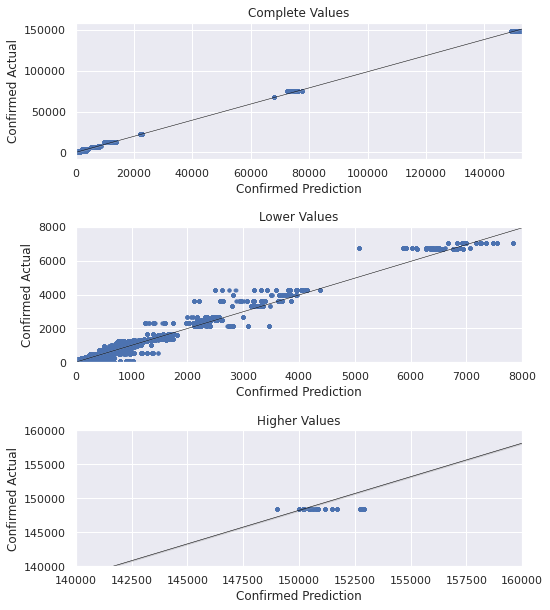

In [8]:
import seaborn as sb
import matplotlib.pyplot as plt
sb.set(color_codes=True)
fig,axs = plt.subplots(nrows=3,figsize=(8,10))
axs[0].set_title('Complete Values')
axs[1].set_title('Lower Values')
axs[1].set_xlim(0,8000)
axs[1].set_ylim(0,8000)
axs[2].set_title('Higher Values')
axs[2].set_xlim(140000,160000)
axs[2].set_ylim(140000,160000)
plt.subplots_adjust(hspace=0.5)
sb.regplot(x=conf_pred, y=conf_actual, data=total_results, marker='.',color='b',ax=axs[0], line_kws={"lw": 0.5, "color": "black"})
sb.regplot(x=conf_pred, y=conf_actual, data=total_results, marker='.',color='b',ax=axs[1],line_kws={"lw": 0.5, "color": "black"})
sb.regplot(x=conf_pred, y=conf_actual, data=total_results, marker='.',color='b',ax=axs[2],line_kws={"lw": 0.5, "color": "black"},truncate=False)

Nos casos confirmados verifica-se bastante proximidade nos valores previstos e reais, nomeadamente quando a ordem de grandeza é mais baixa.

No entanto, existe algum ruído nos valores mais baixo, pelo que se repara que o modelo subestima a contagem dos casos confirmados.

Não obstante tudo o referido e tendo em conta que a maioria das previsões está bastante próxima da realidade, conclui-se que o modelo tenha uma boa previsão dos casos confirmados.

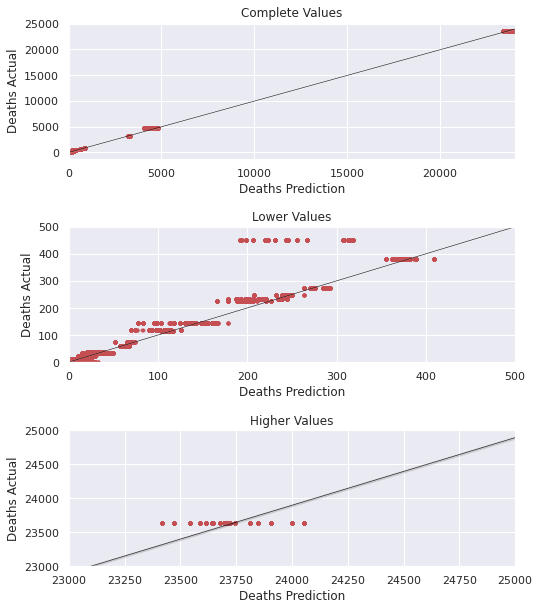

In [9]:
fig,axs = plt.subplots(nrows=3,figsize=(8,10))
axs[0].set_title('Complete Values')
axs[1].set_title('Lower Values')
axs[1].set_xlim(0,500)
axs[1].set_ylim(0,500)
axs[2].set_title('Higher Values')
axs[2].set_xlim(23000,25000)
axs[2].set_ylim(23000,25000)
plt.subplots_adjust(hspace=0.5)
sb.regplot(x=deaths_pred, y=deaths_actual, data=total_results, marker='.',color='r',ax=axs[0], line_kws={"lw": 0.5, "color": "black"})
sb.regplot(x=deaths_pred, y=deaths_actual, data=total_results, marker='.',color='r',ax=axs[1],line_kws={"lw": 0.5, "color": "black"})
sb.regplot(x=deaths_pred, y=deaths_actual, data=total_results, marker='.',color='r',ax=axs[2],line_kws={"lw": 0.5, "color": "black"},truncate=False)

Tal como tinha acontecido com os casos confirmados, verifica-se também o mesmo padrão com os óbitos por covid-19. Os resultados são muito bons com valores de grandeza mais baixa, e com valores de grandeza mais elevada, o erro acentua-se.

Verifica-se que existe uma maior dispersão das previsões com números de menor grandeza, o que não por si não representa um problema muito grande.

O desempenho da previsão do número de óbitos não foi tão satisfátoria quanto se esperaria, mas aceitável com valores mais baixos.

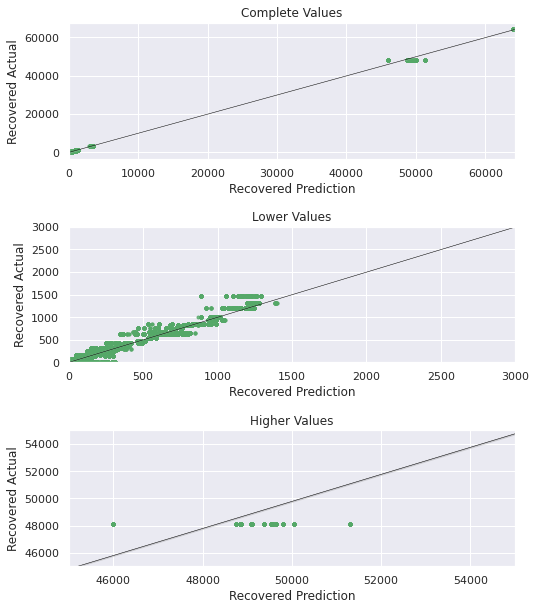

In [10]:
fig,axs = plt.subplots(nrows=3,figsize=(8,10))
axs[0].set_title('Complete Values')
axs[1].set_title('Lower Values')
axs[1].set_xlim(0,3000)
axs[1].set_ylim(0,3000)
axs[2].set_title('Higher Values')
axs[2].set_xlim(45000,55000)
axs[2].set_ylim(45000,55000)
plt.subplots_adjust(hspace=0.5)
sb.regplot(x=recovered_pred, y=recovered_actual, data=total_results, marker='.',color='g',ax=axs[0], line_kws={"lw": 0.5, "color": "black"})
sb.regplot(x=recovered_pred, y=recovered_actual, data=total_results, marker='.',color='g',ax=axs[1],line_kws={"lw": 0.5, "color": "black"})
sb.regplot(x=recovered_pred, y=recovered_actual, data=total_results, marker='.',color='g',ax=axs[2],line_kws={"lw": 0.5, "color": "black"},truncate=False)

A previsão do número de recuperados mantém a tendência verificada na análise das duas outras variáveis.

Os valores mais baixos estão relativamente perto do valor real, com alguma dispersão associada.

Os valores mais elevado, por outro lado, tendem a afastar se mais dos valores reais, verificando-se resultados mais desapontantes.

Estes resultantes verificam-se piores que os restantes observados, mas ainda assim não prejudicam severamente o desempenho do regressor.

### Conclusões KNN

O modelo de regressão teve muito bons resultados na sua generalidade. Certas parametrizações permitiram tirar maior partido do algoritmo e obter melhores resultados.

As previsões de casos confirmados e mortes foram satisfatórias, sendo que as previsões de casos recuperados obtiveram os piores resultados.

Em relação aos tempos de execução estes foram bastante pequenos, pelo que o maior tempo despendido foi no pré-processamento do dataset e na execução total do regressor (todas as combinações), daí que tornou-se pouco relevante analisar comparativamente estes dados. 

De forma geral o algoritmo KNN para regressão funcionou bem para o dataset disponível pelo que estamos satisfeitos com os resultados obtidos.


## Random Forest 

De forma semelhante ao algoritmo anterior, vamos avaliar os erros obtidos, bem como o valor do coeficiente de determinação R². É de relembrar que quanto melhor forem os modelos maior será o valor de R² (1 é o ideal).

Como as combinações são muito grandes (144), vamos primeiro filtrar as opções para o top 5 de cada categoria. Isto é, as combinações que obtiveram melhores resultados no MSE (erro quadrático médio), MAE (erro absoluto médio), R² e tempo.

Posteriormente, analisaremos graficamente os resultados obtidos.

In [11]:
mse_top = [None]*5
mae_top = [None]*5
time_top = [None]*5
r2_top = [None]*5

max_mse = 0
max_mae = 0
max_time = 0
min_r2 = None
for result in results_rf:
    updateMSE(result)
    updateMAE(result)
    updateR2(result)
    updatetime(result)
    if result["mse"] > max_mse:
        max_mse = result["mse"]
    if result["mae"] > max_mae:
        max_mae = result["mae"]
    if result["time"] > max_time:
        max_time = result["time"]
    if min_r2 == None or result["r2"] < min_r2:
        min_r2 = result["r2"]
        
print("Filtered best results.\nMaximum MSE: {}\nMaximum MAE: {}\nMinimum R2: {} \nMaximum Time: {}".format(max_mse,max_mae,min_r2,max_time))


Filtered best results.
Maximum MSE: 80185475.87051281
Maximum MAE: 608.9115384615385
Minimum R2: 0.9673966042377607 
Maximum Time: 30.5036


Agora que temos os melhores resultados, vamos tabelar as melhores combinações e verificar qual/quais se destacam ainda mais.

In [12]:
top_data = set(tuple((top["params"],top["r2"],top["mse"],top["mae"],top["time"]) for top in mse_top))
top_data.update(set(tuple((top["params"],top["r2"],top["mse"],top["mae"],top["time"]) for top in mae_top)))
top_data.update(set(tuple((top["params"],top["r2"],top["mse"],top["mae"],top["time"]) for top in r2_top)))
top_data.update(set(tuple((top["params"],top["r2"],top["mse"],top["mae"],top["time"]) for top in time_top)))

ranking = pd.DataFrame(data=top_data,columns=['Combinations','R2','MSE','MAE','Time'])
ranking = ranking.sort_values(['R2','MSE','MAE','Time'],ascending=[False,True,True,True])
ranking  = ranking.reset_index()
del ranking['index']

with pd.ExcelWriter('covid19_rf_regressor_rank.xlsx') as writer:
    ranking.to_excel(writer)

ranking

,Combinations,R2,MSE,MAE,Time
0,"(500.0, 0.5, 2.0, 2.0)",0.999439,2.925588e+05,55.929487,4.8225
1,"(500.0, 0.5, 4.0, 2.0)",0.999348,2.382354e+05,52.671795,7.4080
2,"(100.0, 0.5, 3.0, 2.0)",0.999336,3.419236e+05,56.138462,1.3604
3,"(100.0, 0.25, 5.0, 2.0)",0.998909,1.589709e+05,56.174359,1.0494
4,"(500.0, 0.25, Default, 2.0)",0.998785,2.350471e+05,52.473077,5.6155
5,"(1000.0, 0.25, Default, 2.0)",0.998465,2.129246e+05,54.478205,11.6429
6,"(500.0, 0.25, 5.0, 4.0)",0.997696,1.947809e+05,59.493590,4.6773
7,"(100.0, 0.1, 3.0, 4.0)",0.989229,1.744488e+07,306.262821,0.4377
8,"(100.0, 0.1, 2.0, 2.0)",0.980288,3.754527e+07,433.438462,0.3891
9,"(100.0, 0.1, 1.0, 2.0)",0.979932,5.162399e+07,499.678205,0.3340


Como se pode verificar, temos algumas combinações de parâmetros que se destacam. 

Ao nível do coeficiente R², todas obtiveram excelentes resultados, o que nos indica que as previsões obtidas se encontram bastante próximas dos dados reais ou seja, este modelo "ajusta-se" bem aos dados (**fitness**). 

Em relação ao erro absoluto médio, o mesmo se verifica, bons resultados na generalidade dos casos. 

Sendo assim, verifica-se que com **número de árvores** a **500** obtém-se melhores resultados. Relativamente ao **max_samples** ,ou seja, a percentagem da amostra de treino que é distribuida a cada árvore, os melhores resultados obtém-se com **0.5** e **0.25**. Para o número de features selecionado em cada ponto de divisão, **max_features** o melhor comportamento obtém-se com o valor **2**. Por fim **min_samples_split** que obteu melhores resultados foi genericamente o **2** apesar de numa combinação em particular o **4** ficou pela segunda posição no ranking. Relativamente aos tempos de execução verificamos que não existe grande diferenciação nos resultados obtidos.

Apesar de todas estas combinações aqui apresentadas serem muito boas, existe uma que supera todas as outras.
Com **números de árvores** a 500, **max_samples** a 0.5  e **max_features** e **min_samples_split** a 2.

### Representação dos Resultados

### Comparação entre diferentes combinações e as suas relações com os valores reais

Para concluir sobre a generalidade do modelo de regressão com o algoritmo RandomForest, vamos apresentar um *regression plot* que para todos os resultados obtidos relacione cada variável dependente prevista e real. Isto é, comparar o rácio de casos confirmados, óbitos e recuperados, previstos e reais.

In [13]:
total_results = results_rf[0]['data']
for i in range(1,len(results_rf)):
    total_results = total_results.append(results_rf[i]['data'],ignore_index=True)
del total_results['Days Passed']
del total_results['Local']
total_results

conf_pred = total_results['Confirmed Prediction']
conf_actual = total_results['Confirmed Actual']
deaths_pred = total_results['Deaths Prediction']
deaths_actual = total_results['Deaths Actual']
recovered_pred = total_results['Recovered Prediction']
recovered_actual = total_results['Recovered Actual']

top_result_conf_pred = r2_top[0]['data']['Confirmed Prediction']
top_result_conf_actual = r2_top[0]['data']['Confirmed Actual']
top_result_deaths_pred = r2_top[0]['data']['Deaths Prediction']
top_result_deaths_actual = r2_top[0]['data']['Deaths Actual']
top_result_recovered_pred = r2_top[0]['data']['Recovered Prediction']
top_result_recovered_actual = r2_top[0]['data']['Recovered Actual']

##### Confirmados

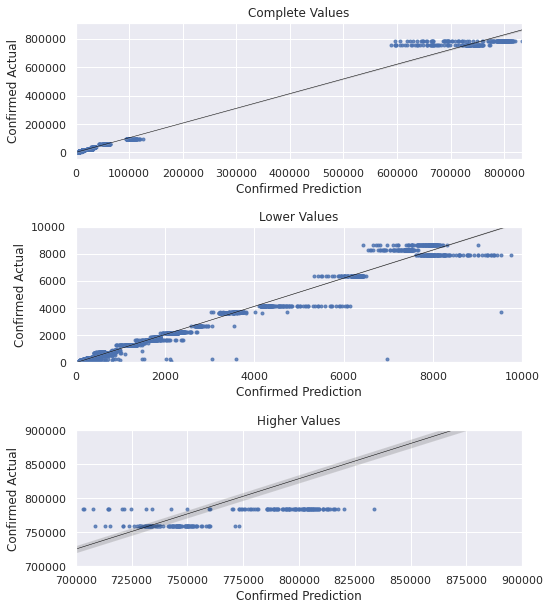

In [14]:
import seaborn as sb
import matplotlib.pyplot as plt

sb.set(color_codes=True)
fig,axs = plt.subplots(nrows=3,figsize=(8,10))
axs[0].set_title('Complete Values')
axs[1].set_title('Lower Values')
axs[1].set_xlim(0,10000)
axs[1].set_ylim(0,10000)
axs[2].set_title('Higher Values')
axs[2].set_xlim(700000,900000)
axs[2].set_ylim(700000,900000)
plt.subplots_adjust(hspace=0.5)
sb.regplot(x=conf_pred, y=conf_actual, data=total_results, marker='.',color='b',ax=axs[0], line_kws={"lw": 0.5, "color": "black"})
sb.regplot(x=conf_pred, y=conf_actual, data=total_results, marker='.',color='b',ax=axs[1],line_kws={"lw": 0.5, "color": "black"})
sb.regplot(x=conf_pred, y=conf_actual, data=total_results, marker='.',color='b',ax=axs[2],line_kws={"lw": 0.5, "color": "black"},truncate=False)

Os valores mais baixos estão relativamente perto do valor real, com alguma dispersão associada.

Os valores mais elevado, por outro lado, tendem a afastar se mais dos valores reais, verificando-se resultados mais desapontantes.

##### Mortes

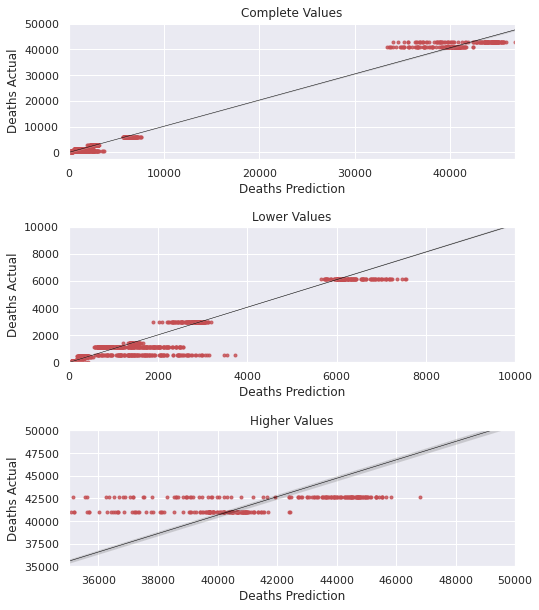

In [15]:
sb.set(color_codes=True)
fig,axs = plt.subplots(nrows=3,figsize=(8,10))
axs[0].set_title('Complete Values')
axs[1].set_title('Lower Values')
axs[1].set_xlim(0,10000)
axs[1].set_ylim(0,10000)
axs[2].set_title('Higher Values')
axs[2].set_xlim(35000,50000)
axs[2].set_ylim(35000,50000)
plt.subplots_adjust(hspace=0.5)
sb.regplot(x=deaths_pred, y=deaths_actual, data=total_results, marker='.',color='r',ax=axs[0], line_kws={"lw": 0.5, "color": "black"})
sb.regplot(x=deaths_pred, y=deaths_actual, data=total_results, marker='.',color='r',ax=axs[1],line_kws={"lw": 0.5, "color": "black"})
sb.regplot(x=deaths_pred, y=deaths_actual, data=total_results, marker='.',color='r',ax=axs[2],line_kws={"lw": 0.5, "color": "black"},truncate=False)

Tanto os valores mais baixos como os mais altos encontram-se relativamente próximos do valor real, apesar de se verificar uma pequena dispersão nalguns pontos

##### Recuperados

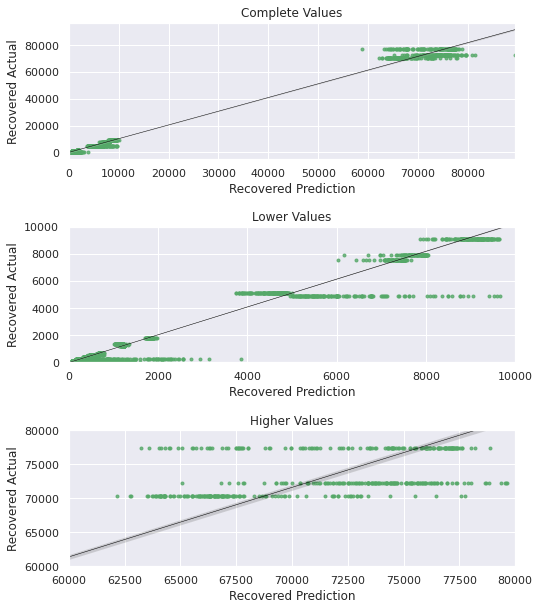

In [16]:
sb.set(color_codes=True)
fig,axs = plt.subplots(nrows=3,figsize=(8,10))
axs[0].set_title('Complete Values')
axs[1].set_title('Lower Values')
axs[1].set_xlim(0,10000)
axs[1].set_ylim(0,10000)
axs[2].set_title('Higher Values')
axs[2].set_xlim(60000,80000)
axs[2].set_ylim(60000,80000)
plt.subplots_adjust(hspace=0.5)
sb.regplot(x=recovered_pred, y=recovered_actual, data=total_results, marker='.',color='g',ax=axs[0], line_kws={"lw": 0.5, "color": "black"})
sb.regplot(x=recovered_pred, y=recovered_actual, data=total_results, marker='.',color='g',ax=axs[1],line_kws={"lw": 0.5, "color": "black"})
sb.regplot(x=recovered_pred, y=recovered_actual, data=total_results, marker='.',color='g',ax=axs[2],line_kws={"lw": 0.5, "color": "black"},truncate=False)

Contrariamente ao que acontecia na variável de confirmados, os valores mais altos estão relativamente perto do valor real. 

Contudo, os valores mais baixos, por outro lado, tendem a afastar se mais dos valores reais, verificando-se resultados muito desapontantes.

### Conclusões RandomForest

Tal como o KNN, este algoritmo teve muito bons resultados na sua generalidade. Certas parametrizações permitiram tirar maior partido do algoritmo e obter melhores resultados.

As previsões de casos confirmados e mortes foram satisfatórias, sendo que as previsões de casos recuperados obtiveram os piores resultados.

Em relação aos tempos de execução estes foram relativamente pequenos e bastante uniformes.

De forma geral o algoritmo Random Forest para regressão funcionou bem para o dataset disponível pelo que estamos satisfeitos com os resultados obtidos.

## SVR

De forma semelhante aos algoritmos anteriores, vamos avaliar os erros obtidos, bem como o valor do coeficiente de determinação R². É de relembrar que quanto melhor forem os modelos maior será o valor de R² (1 é o ideal).

Como as combinações são muito grandes (18), vamos primeiro filtrar as opções para o top 5 de cada categoria. Isto é, as combinações que obtiveram melhores resultados no MSE (erro quadrático médio), MAE (erro absoluto médio), R² e tempo.

Posteriormente, analisaremos graficamente os resultados obtidos.

In [17]:
mse_top = [None]*5
mae_top = [None]*5
time_top = [None]*5
r2_top = [None]*5

max_mse = 0
max_mae = 0
max_time = 0
min_r2 = None
for result in results_svr:
    updateMSE(result)
    updateMAE(result)
    updateR2(result)
    updatetime(result)
    if result["mse"] > max_mse:
        max_mse = result["mse"]
    if result["mae"] > max_mae:
        max_mae = result["mae"]
    if result["time"] > max_time:
        max_time = result["time"]
    if min_r2 == None or result["r2"] < min_r2:
        min_r2 = result["r2"]
        
print("Filtered best results.\nMaximum MSE: {}\nMaximum MAE: {}\nMinimum R2: {} \nMaximum Time: {}".format(max_mse,max_mae,min_r2,max_time))


Filtered best results.
Maximum MSE: 60959141.63717949
Maximum MAE: 1116.597435897436
Minimum R2: 0.6400441420509662 
Maximum Time: 219.1347


In [18]:
top_data = set(tuple((top["params"],top["r2"],top["mse"],top["mae"],top["time"]) for top in mse_top))
top_data.update(set(tuple((top["params"],top["r2"],top["mse"],top["mae"],top["time"]) for top in mae_top)))
top_data.update(set(tuple((top["params"],top["r2"],top["mse"],top["mae"],top["time"]) for top in r2_top)))
top_data.update(set(tuple((top["params"],top["r2"],top["mse"],top["mae"],top["time"]) for top in time_top)))

ranking = pd.DataFrame(data=top_data,columns=['Combinations','R2','MSE','MAE','Time'])
ranking = ranking.sort_values(['R2','MSE','MAE','Time'],ascending=[False,True,True,True])
ranking  = ranking.reset_index()
del ranking['index']

with pd.ExcelWriter('covid19_knn_regressor_rank.xlsx') as writer:
    ranking.to_excel(writer)

ranking

,Combinations,R2,MSE,MAE,Time
0,"(poly, 1, 10, auto)",0.805291,4.295898e+07,937.993590,210.0792
1,"(poly, 1, 10, scale)",0.805291,4.295898e+07,937.993590,219.1347
2,"(poly, 0.2, 10, scale)",0.805255,4.295983e+07,937.987179,159.1613
3,"(poly, 0.2, 10, auto)",0.805255,4.295983e+07,937.987179,163.5467
4,"(poly, 0.1, 10, scale)",0.805254,4.295979e+07,937.980769,178.7866
5,"(poly, 0.1, 10, auto)",0.805254,4.295979e+07,937.980769,180.5983
6,"(poly, 1, 1, auto)",0.640100,6.095862e+07,1116.597436,67.3304
7,"(poly, 1, 1, scale)",0.640100,6.095862e+07,1116.597436,67.7108
8,"(poly, 0.2, 1, auto)",0.640045,6.095914e+07,1116.593590,91.8192
9,"(poly, 0.1, 1, auto)",0.640044,6.095898e+07,1116.585897,62.5515


Como se pode verificar, temos algumas combinações de parâmetros que se destacam. 

Ao nível do coeficiente R², todas obtiveram resultados medianos, com os melhores a chegar ao 0.80, o que nos indica que as previsões obtidas se encontram próximas dos dados reais, mas não tão próximas como desejariamos, ou seja, este modelo não se "ajusta" na perfeição aos dados (**fitness**). 

Em relação ao erro absoluto médio, observam-se resultados medianos na generalidade dos casos. 

Sendo assim, verifica-se que com **C** a **10** se obtém os melhores resultados, ou seja atribuindo uma maior penalização a erros. Curiosamente, de forma oposta, uma maior margem de tolerância onde não é atribuida penalidade a erros obtém melhores resultados, já que o maior valor de **epsilon** ,**1** obtém melhores resultados, seguindo-se do **0.2** e do **0.1**. Em relação a **gamma** destaca-se nos primeiros o **scale** apesar da opção **auto** não eliminar completamente a possibilidade de obter bons resultados. Também de notar que opções com melhores resultados são as que mais tempo demoram a executar.

Apesar de todas estas combinações aqui apresentadas serem muito boas, existe uma que supera todas as outras.
Com **kernel=poly**, **peso** com base em **distância**, **epsilon** de **1**, **C** de 10, e **gamma** a scale, obteve-se os melhores resultados do modelo de regressão *Suport Vector Regressor*.

### Representação dos Resultados

### Comparação entre diferentes combinações e as suas relações com os valores reais

Para concluir sobre a generalidade do modelo de regressão com o algoritmo SVR, vamos apresentar um *regression plot* que para todos os resultados obtidos relacione cada variável dependente prevista e real. Isto é, comparar o rácio de casos confirmados, óbitos e recuperados, previstos e reais.

In [19]:
total_results = results_svr[0]['data']
for i in range(1,len(results_svr)):
    total_results = total_results.append(results_svr[i]['data'],ignore_index=True)
del total_results['Days Passed']
del total_results['Local']
total_results

conf_pred = total_results['Confirmed Prediction']
conf_actual = total_results['Confirmed Actual']
deaths_pred = total_results['Deaths Prediction']
deaths_actual = total_results['Deaths Actual']
recovered_pred = total_results['Recovered Prediction']
recovered_actual = total_results['Recovered Actual']

top_result_conf_pred = r2_top[0]['data']['Confirmed Prediction']
top_result_conf_actual = r2_top[0]['data']['Confirmed Actual']
top_result_deaths_pred = r2_top[0]['data']['Deaths Prediction']
top_result_deaths_actual = r2_top[0]['data']['Deaths Actual']
top_result_recovered_pred = r2_top[0]['data']['Recovered Prediction']
top_result_recovered_actual = r2_top[0]['data']['Recovered Actual']

##### Confirmados

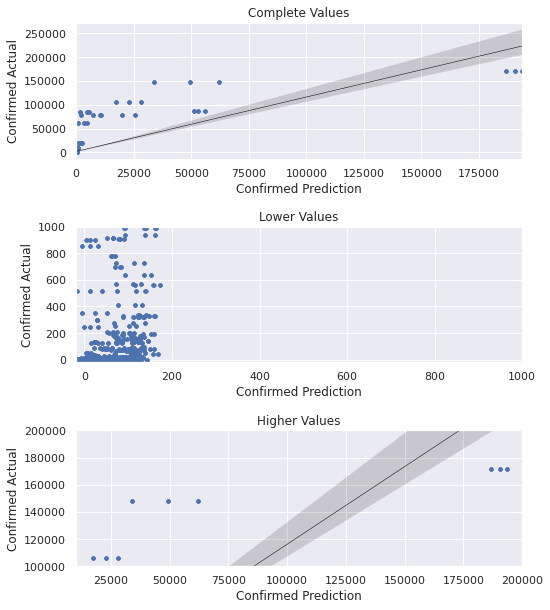

In [20]:
import seaborn as sb
import matplotlib.pyplot as plt
sb.set(color_codes=True)
fig,axs = plt.subplots(nrows=3,figsize=(8,10))
axs[0].set_title('Complete Values')
axs[1].set_title('Lower Values')
axs[1].set_xlim(-20,1000)
axs[1].set_ylim(-20,1000)
axs[2].set_title('Higher Values')
axs[2].set_xlim(10000,200000)
axs[2].set_ylim(100000,200000)
plt.subplots_adjust(hspace=0.5)
sb.regplot(x=conf_pred, y=conf_actual, data=total_results, marker='.',color='b',ax=axs[0], line_kws={"lw": 0.5, "color": "black"})
sb.regplot(x=conf_pred, y=conf_actual, data=total_results, marker='.',color='b',ax=axs[1],line_kws={"lw": 0.5, "color": "black"})
sb.regplot(x=conf_pred, y=conf_actual, data=total_results, marker='.',color='b',ax=axs[2],line_kws={"lw": 0.5, "color": "black"})

Tal como se vinha a esperar com base nos resultados obtidos relativamente aos parâmetros estatísticos os resultados obtidos são bastante desapontantes.

A dispersão dos resultados relativamente aos valores reais é considerável para todos os valores em estudo.

##### Mortes

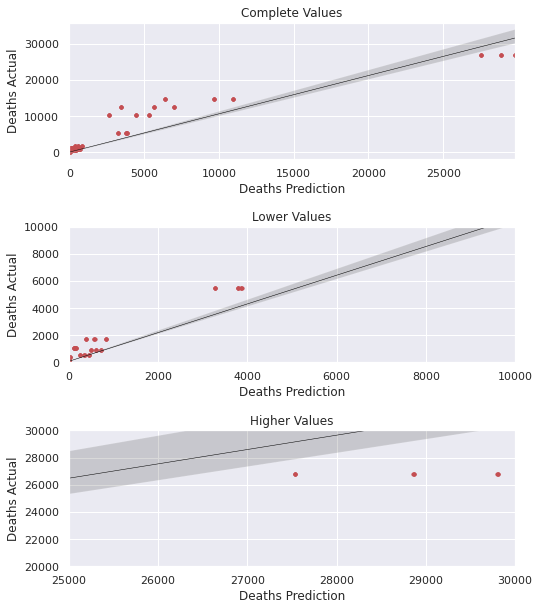

In [21]:
sb.set(color_codes=True)
fig,axs = plt.subplots(nrows=3,figsize=(8,10))
axs[0].set_title('Complete Values')
axs[1].set_title('Lower Values')
axs[1].set_xlim(0,10000)
axs[1].set_ylim(0,10000)
axs[2].set_title('Higher Values')
axs[2].set_xlim(25000,30000)
axs[2].set_ylim(20000,30000)
plt.subplots_adjust(hspace=0.5)
sb.regplot(x=deaths_pred, y=deaths_actual, data=total_results, marker='.',color='r',ax=axs[0], line_kws={"lw": 0.5, "color": "black"})
sb.regplot(x=deaths_pred, y=deaths_actual, data=total_results, marker='.',color='r',ax=axs[1],line_kws={"lw": 0.5, "color": "black"})
sb.regplot(x=deaths_pred, y=deaths_actual, data=total_results, marker='.',color='r',ax=axs[2],line_kws={"lw": 0.5, "color": "black"})

No caso desta variável, apesar do desempenho continuar muito aquém daquilo que gostaríamos de obter, observa-se uma melhoria geral relativamente à dispersão de todos os valores em relação aos valores reais.

##### Recuperados

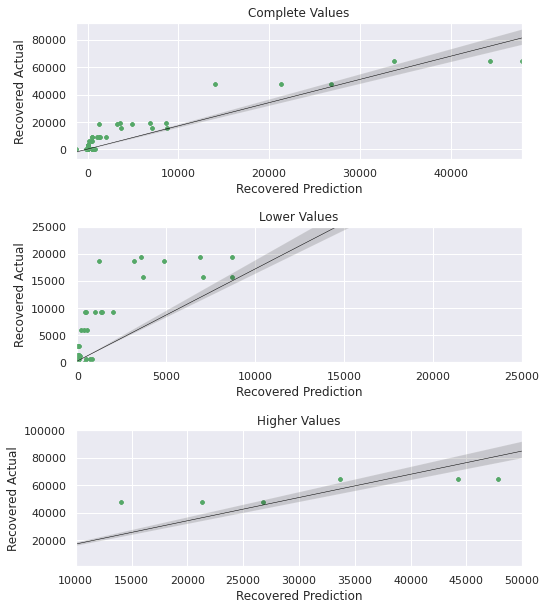

In [22]:
sb.set(color_codes=True)
fig,axs = plt.subplots(nrows=3,figsize=(8,10))
axs[0].set_title('Complete Values')
axs[1].set_title('Lower Values')
axs[1].set_xlim(-100,25000)
axs[1].set_ylim(0,25000)
axs[2].set_title('Higher Values')
axs[2].set_xlim(10000,50000)
axs[2].set_ylim(1000,100000)
plt.subplots_adjust(hspace=0.5)
sb.regplot(x=recovered_pred, y=recovered_actual, data=total_results, marker='.',color='g',ax=axs[0], line_kws={"lw": 0.5, "color": "black"})
sb.regplot(x=recovered_pred, y=recovered_actual, data=total_results, marker='.',color='g',ax=axs[1],line_kws={"lw": 0.5, "color": "black"})
sb.regplot(x=recovered_pred, y=recovered_actual, data=total_results, marker='.',color='g',ax=axs[2],line_kws={"lw": 0.5, "color": "black"},truncate=False)

Novamente existe bastante dispersão dos resultados relativamente aos reais.

Para valores mais baixos esta dispersão é extremamente significativa.

Para valores mais elevados, a dispersão é um pouco menor.

### Conclusões SVR

Ao contrário dos outros algoritmos, os resultados obtidos foram bastante pobres.

Todas as previsões apresentam bastante dispersão, apesar da variável de mortes ser a que obteve melhores resultados.

Além disso, os tempos de execução deste algoritmo foram extremamente elevados comparativamente aos restantes algoritmos.

De forma geral o algoritmo Support Vector Machine para regressão funcionou de forma pobre para o dataset disponível pelo que estamos insastisfeitos com os resultados obtidos.

## Linear Regression

In [23]:
results_lr = {"data": predictions_lr}
total_results = results_lr['data']

for i in range(1,len(results_lr)):
    total_results = total_results.append(results_lr['data'],ignore_index=True)
del total_results['Days Passed']
del total_results['Local']
total_results

conf_pred = total_results['Confirmed Prediction']
conf_actual = total_results['Confirmed Actual']
deaths_pred = total_results['Deaths Prediction']
deaths_actual = total_results['Deaths Actual']
recovered_pred = total_results['Recovered Prediction']
recovered_actual = total_results['Recovered Actual']

total_results

NameError: name 'predictions_lr' is not defined

In [ ]:
from sklearn.metrics import *

mse = mean_squared_error(y_test,y_pred)
mae = mean_absolute_error(y_test,y_pred)
r2  = r2_score(y_test,y_pred)

print("Mean Squared Error: {}\nMean Absolute Error: {}\nR²: {}".format(mse,mae,r2))

In [ ]:
Estes valores são surpreendentemente bons, o que nos leva a crer que o dataset de teste tinha uma distribuição não muito longe de linear. 

In [ ]:
import seaborn as sb
import matplotlib.pyplot as plt
sb.set(color_codes=True)
fig,axs = plt.subplots(nrows=3,figsize=(8,10))
axs[0].set_title('Complete Values')
axs[1].set_title('Lower Values')
axs[1].set_xlim(-100,2000)
axs[1].set_ylim(-100,2000)
axs[2].set_title('Higher Values')
axs[2].set_xlim(2000,140000)
axs[2].set_ylim(2000,140000)
plt.subplots_adjust(hspace=0.5)
sb.regplot(x=conf_pred, y=conf_actual, data=total_results, marker='.',color='b',ax=axs[0], line_kws={"lw": 0.5, "color": "black"},truncate=False)
sb.regplot(x=conf_pred, y=conf_actual, data=total_results, marker='.',color='b',ax=axs[1],line_kws={"lw": 0.5, "color": "black"},truncate=False)
sb.regplot(x=conf_pred, y=conf_actual, data=total_results, marker='.',color='b',ax=axs[2],line_kws={"lw": 0.5, "color": "black"},truncate=False)

In [ ]:
fig,axs = plt.subplots(nrows=3,figsize=(8,10))
axs[0].set_title('Complete Values')
axs[1].set_title('Lower Values')
axs[1].set_xlim(-20,500)
axs[1].set_ylim(-20,500)
axs[2].set_title('Higher Values')
axs[2].set_xlim(1000,18000)
axs[2].set_ylim(1000,18000)
plt.subplots_adjust(hspace=0.5)
sb.regplot(x=deaths_pred, y=deaths_actual, data=total_results, marker='.',color='r',ax=axs[0], line_kws={"lw": 0.5, "color": "black"},truncate=False)
sb.regplot(x=deaths_pred, y=deaths_actual, data=total_results, marker='.',color='r',ax=axs[1],line_kws={"lw": 0.5, "color": "black"},truncate=False)
sb.regplot(x=deaths_pred, y=deaths_actual, data=total_results, marker='.',color='r',ax=axs[2],line_kws={"lw": 0.5, "color": "black"},truncate=False)

In [ ]:
fig,axs = plt.subplots(nrows=3,figsize=(8,10))
axs[0].set_title('Complete Values')
axs[1].set_title('Lower Values')
axs[1].set_xlim(-30,1000)
axs[1].set_ylim(-30,1000)
axs[2].set_title('Higher Values')
axs[2].set_xlim(10000,60000)
axs[2].set_ylim(10000,60000)
plt.subplots_adjust(hspace=0.5)
sb.regplot(x=recovered_pred, y=recovered_actual, data=total_results, marker='.',color='g',ax=axs[0], line_kws={"lw": 0.5, "color": "black"},truncate=False)
sb.regplot(x=recovered_pred, y=recovered_actual, data=total_results, marker='.',color='g',ax=axs[1],line_kws={"lw": 0.5, "color": "black"},truncate=False)
sb.regplot(x=recovered_pred, y=recovered_actual, data=total_results, marker='.',color='g',ax=axs[2],line_kws={"lw": 0.5, "color": "black"},truncate=False)

### Conclusões Linear Regression

A análise destes gráficos demonstra que existe uma maior dispersão na previsão de valores mais baixos(associados aos primeiros dias do dataset), o que é algo previsível, uma vez que a maioria dos locais apresentam valores a 0 nesses primeiros dias para as várias variáveis independentes.

Os valores mais elevados, apesar de menos frequentes, são uma boa previsão em relação as valores reais.

É também de salientar que, uma vez que o algoritmo tenta criar uma reta que melhor se adequa aos dados de treino, alguns dos valores previstos para os primeiros dias acabam por ser negativos

In [ ]:
with pd.ExcelWriter('covid_19_linear_predictions.xlsx') as writer:
    predictions_lr.to_excel(writer)

# Conclusões

# Referências

* “Scikit-Learn: Machine Learning in Python — Scikit-Learn 0.23.1 Documentation.” Accessed May 28, 2020. https://scikit-learn.org/stable/index.html.

* Brownlee, Jason. «How to Develop a Random Forest Ensemble in Python». Machine Learning Mastery, 19 de Abril de 2020, https://machinelearningmastery.com/random-forest-ensemble-in-python/.